In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
##from pandas.plotting import parallel_coordinates
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn import tree
plt.style.use("seaborn-dark")

In [4]:
df = pd.read_csv(r'..\data\raw\weatherAUS.csv')

<h3> Cantidad de lugares distintos de la base de datos </h3>

In [5]:
len(df['Location'].unique())

49

<h4> Hacemos una copia del la base de datos para cambiar los valores de 'yes' y 'no' por valores booleanos en la copia del DF </h4>

In [11]:
data = df.copy()

In [44]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [9]:
len(df)

145460

In [7]:
df['RainTomorrow'].value_counts()

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

In [12]:
data['RainToday'] = (data['RainToday'] == 'Yes')*1
data['RainTomorrow'] = (data['RainTomorrow'] == 'Yes')*1

<h4>Cambiamos las abreviaciones de las direcciones del viento en las respectivas columnas </h4>

In [28]:
replace_values = {'N':0,'NNE':22.5,'NE':45,'ENE':67.5,'E':90,'ESE':112.5,'SE':135,'SSE':157.5,'S':180,'SSW':202.5,'SW':225,'WSW':247.5,'W':270,'WNW':292.5,'NW':315,'NNW':337.5}

In [31]:
df.loc[:,['WindGustDir','WindDir9am','WindDir3pm']].replace(replace_values, )

,WindGustDir,WindDir9am,WindDir3pm
0,270.0,270.0,292.5
1,292.5,337.5,247.5
2,247.5,270.0,247.5
3,45.0,135.0,90.0
4,270.0,67.5,315.0
...,...,...,...
145455,90.0,135.0,67.5
145456,337.5,135.0,0.0
145457,0.0,135.0,292.5
145458,135.0,157.5,0.0


In [32]:
Col_WindDir=['WindGustDir','WindDir9am','WindDir3pm']
for j in Col_WindDir:
    for i in Wind_Dir.index:
        data.loc[data[j] == Wind_Dir.iloc[i][0], j]= Wind_Dir.iloc[i][1]

<h4> Ahora veamos la cantidad de valores nulos que hay en la base de datos</h4>

<h4>Cantidad de calores nulos </h4>

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

<h4>Calculemos los coeficientes de correlación de la base de datos para darnos una idea de que columnas pueden ser de utlidad y cuales no. </h4>

<h4> Visualicemos esto con un gráfico </h4>

<AxesSubplot:>

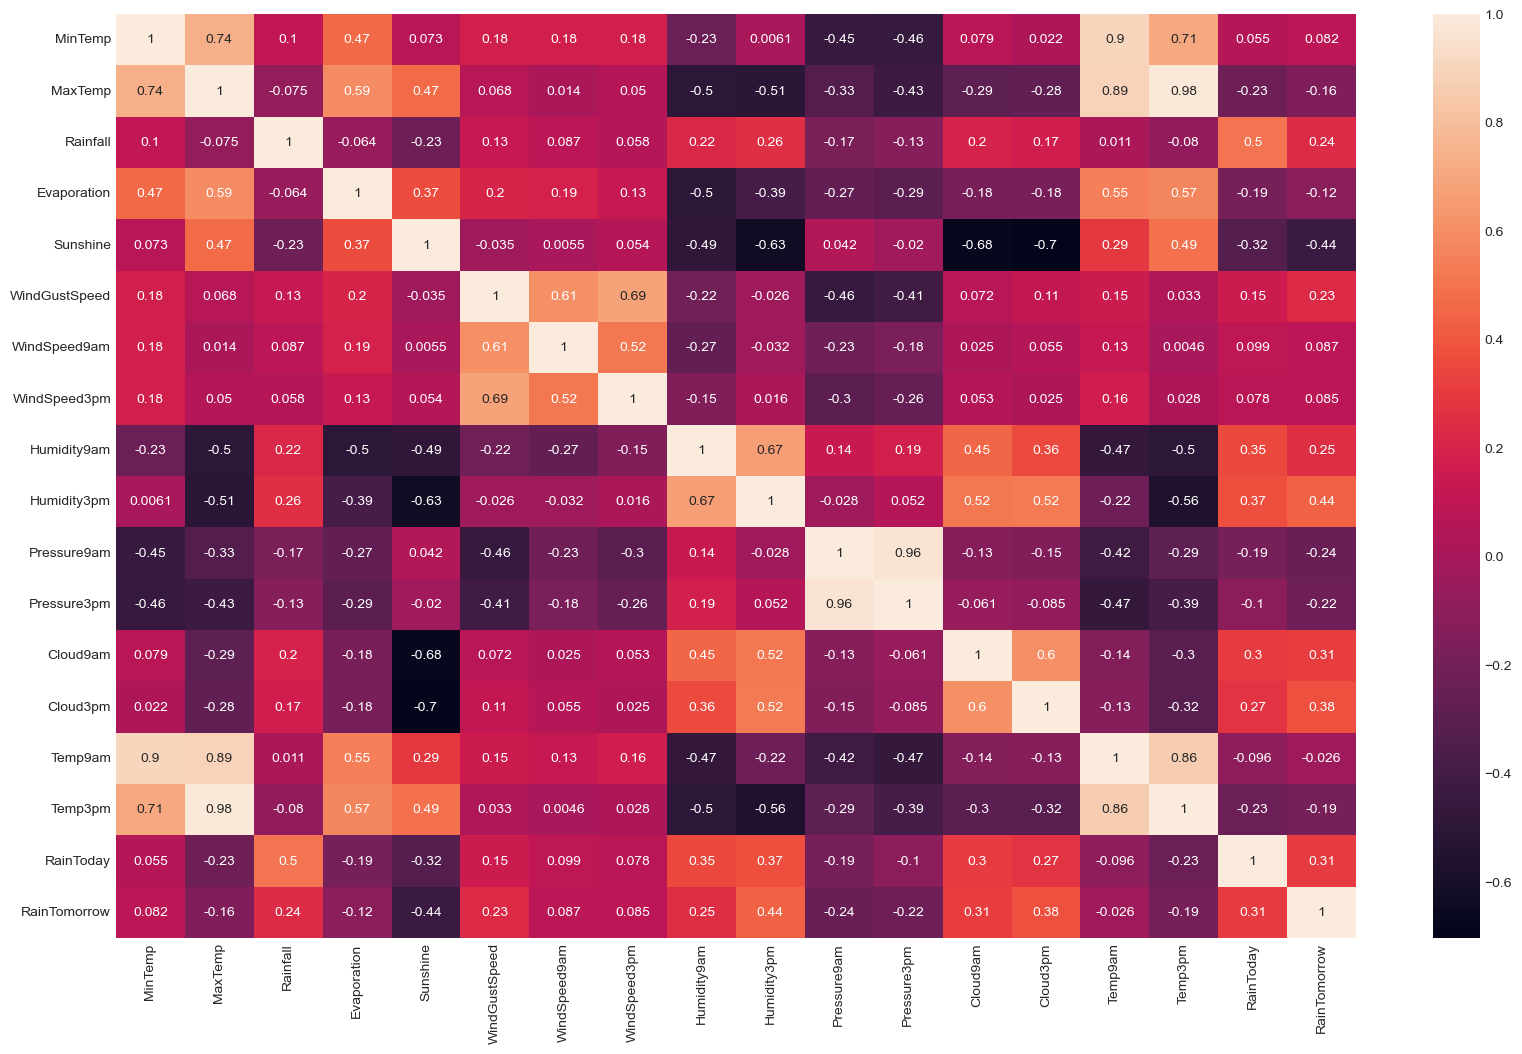

In [35]:
cor_data = data.corr()
plt.figure(figsize=(20,12))
sns.heatmap(cor_data,annot=True)

<h4>Cantidad de calores nulos en porcentaje </h4>

In [95]:
import missingno as msno

In [74]:
null = data.loc[:,["Date","Location","Sunshine","Evaporation","Cloud3pm","Cloud9am","Pressure9am","Pressure3pm", "RainToday","RainTomorrow"]].copy()

In [ ]:
# Filtering by date except specific months
null['Date'] = pd.to_datetime(null['Date'])
null = null.set_index('Date')

In [102]:
null[null.index.month.isin([1,2,3,4,5,6,7,8,9,10,11])]

,Location,Sunshine,Evaporation,Cloud3pm,Cloud9am,Pressure9am,Pressure3pm,RainToday,RainTomorrow
Date,,,,,,,,,
2009-01-01,Albury,NaN,NaN,NaN,NaN,1004.5,1003.2,0,0
2009-01-02,Albury,NaN,NaN,NaN,NaN,1014.4,1013.1,0,0
2009-01-03,Albury,NaN,NaN,NaN,NaN,1018.7,1014.8,0,0
2009-01-04,Albury,NaN,NaN,NaN,NaN,1015.1,1010.3,0,0
2009-01-05,Albury,NaN,NaN,NaN,NaN,1012.6,1009.2,0,0
...,...,...,...,...,...,...,...,...,...
2017-06-21,Uluru,NaN,NaN,NaN,NaN,1024.6,1020.3,0,0
2017-06-22,Uluru,NaN,NaN,NaN,NaN,1023.5,1019.1,0,0
2017-06-23,Uluru,NaN,NaN,NaN,NaN,1021.0,1016.8,0,0


In [119]:
null[null.index.month.isin([7])].isnull().sum()*100/len(null[null.index.month.isin([7])])

Location         0.000000
Sunshine        46.819127
Evaporation     41.164241
Cloud3pm        37.097713
Cloud9am        36.024948
Pressure9am     10.054054
Pressure3pm     10.095634
RainToday        0.000000
RainTomorrow     0.000000
dtype: float64

<AxesSubplot:>

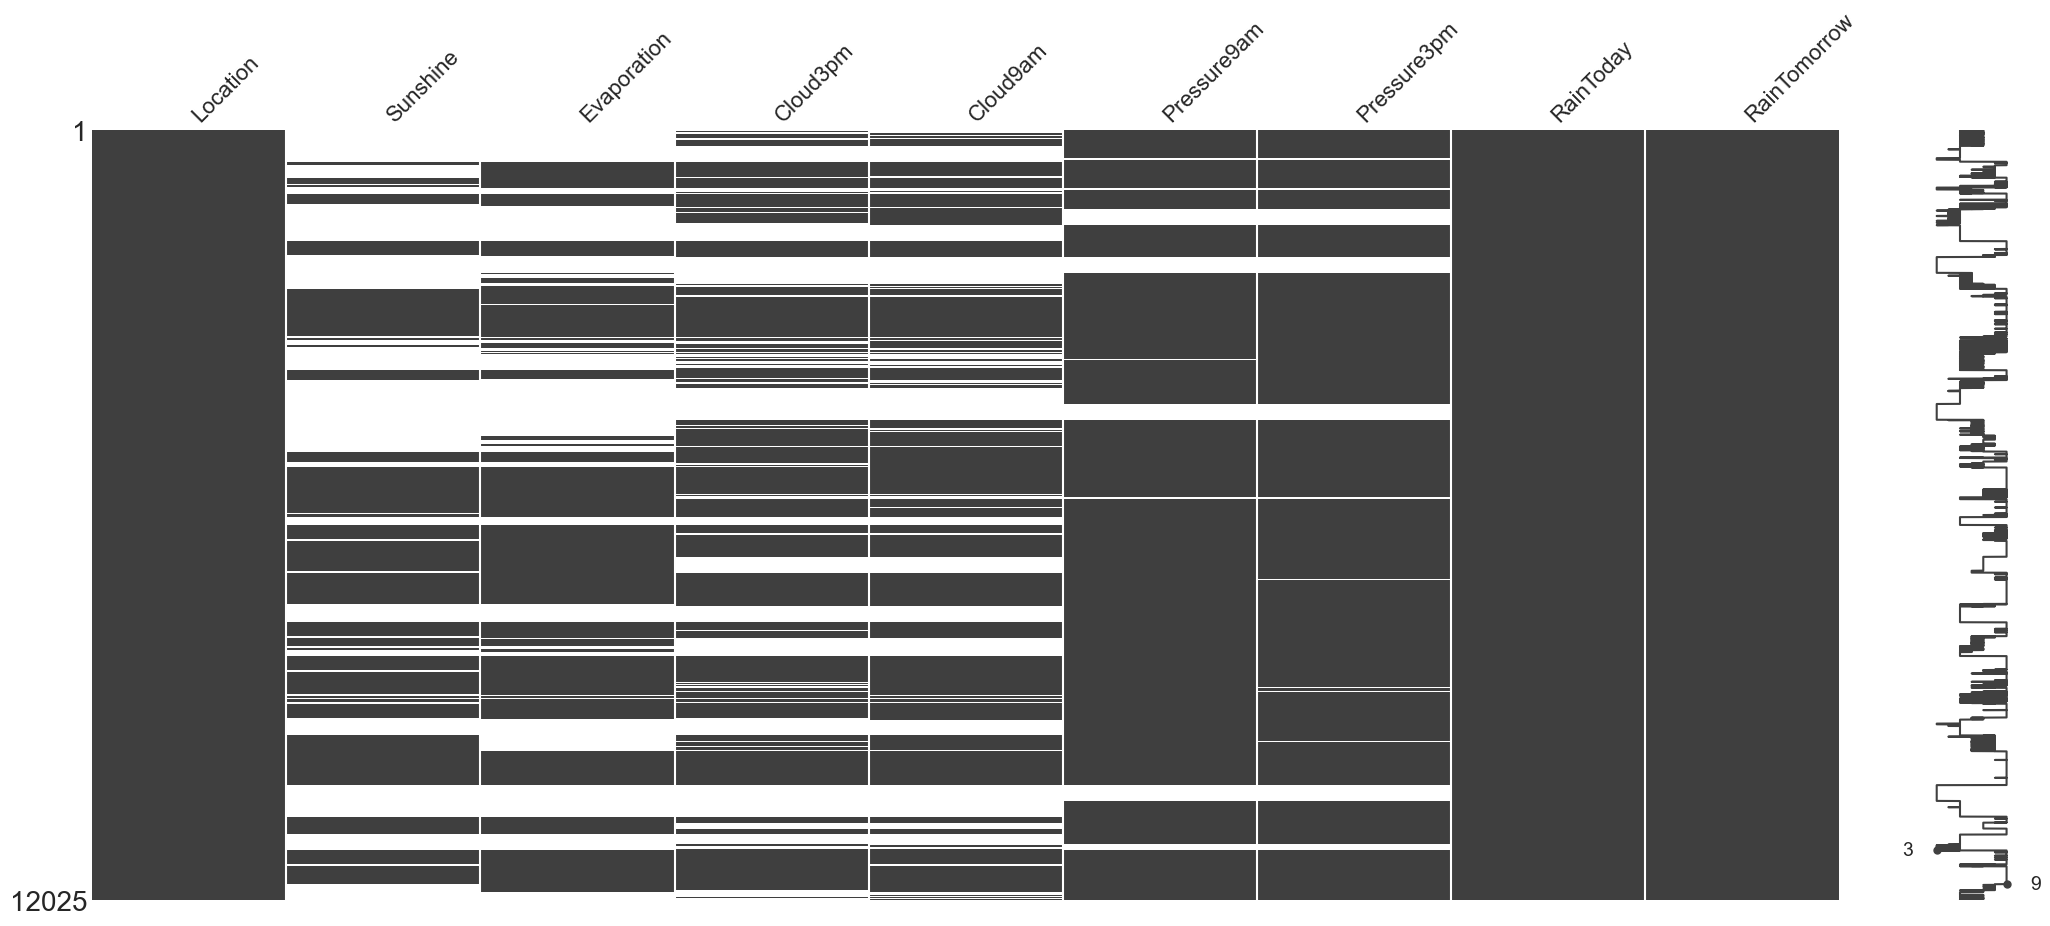

In [120]:
msno.matrix(null[null.index.month.isin([7])])

In [92]:
null.iloc[[0,-1],:]

,Date,Location,Sunshine,Evaporation,Cloud3pm,Cloud9am,Pressure9am,Pressure3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,NaN,NaN,NaN,8.0,1007.7,1007.1,0,0
145459,2017-06-25,Uluru,NaN,NaN,8.0,8.0,1020.2,1017.9,0,0


In [37]:
(data.isnull().sum()*100)/len(data.index)

Date              0.000000
Location          0.000000
MinTemp           1.020899
MaxTemp           0.866905
Rainfall          2.241853
Evaporation      43.166506
Sunshine         48.009762
WindGustDir       7.098859
WindGustSpeed     7.055548
WindDir9am        7.263853
WindDir3pm        2.906641
WindSpeed9am      1.214767
WindSpeed3pm      2.105046
Humidity9am       1.824557
Humidity3pm       3.098446
Pressure9am      10.356799
Pressure3pm      10.331363
Cloud9am         38.421559
Cloud3pm         40.807095
Temp9am           1.214767
Temp3pm           2.481094
RainToday         0.000000
RainTomorrow      0.000000
dtype: float64

<h4>Dado que queremos un modelo que prediga si lloverá o no en una o varias de las ciudades de la base de datos, lo que haremos será optar por predecir con un modelo de árbol de desiciones (clasificador) </h4>

<h4>Puesto que queremos predecir especificamente en cada ciudad, como primer acercamiento separaremos los datos de cada ciudad en la base de datos y la limpiaremos para proceder a crear el modelo. </h4>

Para esto creamos un diccionario que contenga las bases de datos de cada lugar


In [69]:
data['Location'].unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

In [39]:
Loc = data['Location'].unique()
{elem : pd.DataFrame() for elem in Loc}

{'Albury': Empty DataFrame
 Columns: []
 Index: [],
 'BadgerysCreek': Empty DataFrame
 Columns: []
 Index: [],
 'Cobar': Empty DataFrame
 Columns: []
 Index: [],
 'CoffsHarbour': Empty DataFrame
 Columns: []
 Index: [],
 'Moree': Empty DataFrame
 Columns: []
 Index: [],
 'Newcastle': Empty DataFrame
 Columns: []
 Index: [],
 'NorahHead': Empty DataFrame
 Columns: []
 Index: [],
 'NorfolkIsland': Empty DataFrame
 Columns: []
 Index: [],
 'Penrith': Empty DataFrame
 Columns: []
 Index: [],
 'Richmond': Empty DataFrame
 Columns: []
 Index: [],
 'Sydney': Empty DataFrame
 Columns: []
 Index: [],
 'SydneyAirport': Empty DataFrame
 Columns: []
 Index: [],
 'WaggaWagga': Empty DataFrame
 Columns: []
 Index: [],
 'Williamtown': Empty DataFrame
 Columns: []
 Index: [],
 'Wollongong': Empty DataFrame
 Columns: []
 Index: [],
 'Canberra': Empty DataFrame
 Columns: []
 Index: [],
 'Tuggeranong': Empty DataFrame
 Columns: []
 Index: [],
 'MountGinini': Empty DataFrame
 Columns: []
 Index: [],
 'Bal

In [40]:
Loc = data['Location'].unique()
df_dict_Loc = {elem : pd.DataFrame() for elem in Loc}
for key in df_dict_Loc.keys():
    df_dict_Loc[key] = data[:][data.Location == key]
df_dict_Loc

{'Albury':             Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
 0     2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
 1     2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
 2     2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
 3     2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
 4     2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   
 ...          ...      ...      ...      ...       ...          ...       ...   
 3035  2017-06-21   Albury      1.2     15.2       0.4          NaN       NaN   
 3036  2017-06-22   Albury      0.8     13.4       0.0          NaN       NaN   
 3037  2017-06-23   Albury      1.1     11.9       0.0          NaN       NaN   
 3038  2017-06-24   Albury      1.1     14.1       0.2          NaN       NaN   
 3039  2017-06-25   Albury      3.9     10.9       0.0          NaN       NaN   
 
      WindGustDi

In [41]:
df_dict_Loc

{'Albury':             Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
 0     2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
 1     2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
 2     2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
 3     2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
 4     2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   
 ...          ...      ...      ...      ...       ...          ...       ...   
 3035  2017-06-21   Albury      1.2     15.2       0.4          NaN       NaN   
 3036  2017-06-22   Albury      0.8     13.4       0.0          NaN       NaN   
 3037  2017-06-23   Albury      1.1     11.9       0.0          NaN       NaN   
 3038  2017-06-24   Albury      1.1     14.1       0.2          NaN       NaN   
 3039  2017-06-25   Albury      3.9     10.9       0.0          NaN       NaN   
 
      WindGustDi

Ahora procedemos a limpiar cada base de datos. 

Lo primero sera ver cuantos (porcentaje) valores nulos hay en cada base de datos.

In [42]:
null_val_perc = {elem : pd.Series(dtype='float64') for elem in Loc}
for key in df_dict_Loc.keys():
    null_val_perc[key] = (df_dict_Loc[key].isnull().sum()*100)/len(df_dict_Loc[key].index)

In [43]:
null_val_perc

{'Albury': Date               0.000000
 Location           0.000000
 MinTemp            0.361842
 MaxTemp            0.361842
 Rainfall           0.953947
 Evaporation      100.000000
 Sunshine         100.000000
 WindGustDir        1.052632
 WindGustSpeed      1.052632
 WindDir9am        17.269737
 WindDir3pm         1.513158
 WindSpeed9am       0.296053
 WindSpeed3pm       0.361842
 Humidity9am        0.296053
 Humidity3pm        0.263158
 Pressure9am        0.164474
 Pressure3pm        0.263158
 Cloud9am          57.598684
 Cloud3pm          53.059211
 Temp9am            0.296053
 Temp3pm            0.263158
 RainToday          0.000000
 RainTomorrow       0.000000
 dtype: float64,
 'BadgerysCreek': Date               0.000000
 Location           0.000000
 MinTemp            1.196411
 MaxTemp            0.963775
 Rainfall           2.691924
 Evaporation      100.000000
 Sunshine         100.000000
 WindGustDir        2.525756
 WindGustSpeed      2.525756
 WindDir9am        14.456630

Veamos las columnas con mas valores nulos y borremos las columnas que tengan todos sus valores nulos

In [45]:
for key in null_val_perc.keys():
    for col in df_dict_Loc[key].columns:
        if null_val_perc[key][col] == 100.0:
            df_dict_Loc[key]=df_dict_Loc[key].drop([col],axis=1)
            null_val_perc[key]=null_val_perc[key].drop([col])

In [46]:
df_dict_Loc

{'Albury':             Date Location  MinTemp  MaxTemp  Rainfall WindGustDir  \
 0     2008-12-01   Albury     13.4     22.9       0.6       270.0   
 1     2008-12-02   Albury      7.4     25.1       0.0       292.5   
 2     2008-12-03   Albury     12.9     25.7       0.0       247.5   
 3     2008-12-04   Albury      9.2     28.0       0.0        45.0   
 4     2008-12-05   Albury     17.5     32.3       1.0       270.0   
 ...          ...      ...      ...      ...       ...         ...   
 3035  2017-06-21   Albury      1.2     15.2       0.4        67.5   
 3036  2017-06-22   Albury      0.8     13.4       0.0       270.0   
 3037  2017-06-23   Albury      1.1     11.9       0.0       135.0   
 3038  2017-06-24   Albury      1.1     14.1       0.2       247.5   
 3039  2017-06-25   Albury      3.9     10.9       0.0       337.5   
 
       WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  ...  Humidity9am  \
 0              44.0      270.0      292.5          20.0  ...         

In [47]:
null_val_perc

{'Albury': Date              0.000000
 Location          0.000000
 MinTemp           0.361842
 MaxTemp           0.361842
 Rainfall          0.953947
 WindGustDir       1.052632
 WindGustSpeed     1.052632
 WindDir9am       17.269737
 WindDir3pm        1.513158
 WindSpeed9am      0.296053
 WindSpeed3pm      0.361842
 Humidity9am       0.296053
 Humidity3pm       0.263158
 Pressure9am       0.164474
 Pressure3pm       0.263158
 Cloud9am         57.598684
 Cloud3pm         53.059211
 Temp9am           0.296053
 Temp3pm           0.263158
 RainToday         0.000000
 RainTomorrow      0.000000
 dtype: float64,
 'BadgerysCreek': Date              0.000000
 Location          0.000000
 MinTemp           1.196411
 MaxTemp           0.963775
 Rainfall          2.691924
 WindGustDir       2.525756
 WindGustSpeed     2.525756
 WindDir9am       14.456630
 WindDir3pm        2.824859
 WindSpeed9am      1.628448
 WindSpeed3pm      1.595214
 Humidity9am       1.794616
 Humidity3pm       1.827850
 Pre

Dado que todavia hay columnas con valores nulos, en esta ocasión optaremos por rellenar los valores con la media o moda dependiendo del tipo de datos.

Columnas que se rellenan con la moda.

In [48]:
Col_Mode =['WindGustDir','WindDir9am','WindDir3pm','Cloud9am','Cloud3pm']
for key in df_dict_Loc.keys():
    for col in Col_Mode:
        if col in df_dict_Loc[key].columns:
            df_dict_Loc[key][col]=df_dict_Loc[key][col].fillna(df_dict_Loc[key][col].mode()[0])

Columnas que se rellenan con la media.

In [49]:
for key in df_dict_Loc.keys():
    df_dict_Loc[key].fillna(df_dict_Loc[key].mean(), inplace=True)

C:\Users\mario\AppData\Local\Temp\ipykernel_20128\331063458.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_dict_Loc[key].fillna(df_dict_Loc[key].mean(), inplace=True)
C:\Users\mario\AppData\Local\Temp\ipykernel_20128\331063458.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_dict_Loc[key].fillna(df_dict_Loc[key].mean(), inplace=True)
C:\Users\mario\AppData\Local\Temp\ipykernel_20128\331063458.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default t

Ahora no hay base de datos con valores nulos. Corroboremos esto.

In [50]:
null_val_perc = {elem : pd.Series(dtype='float64') for elem in Loc}
for key in df_dict_Loc.keys():
    null_val_perc[key] = (df_dict_Loc[key].isnull().sum()*100)/len(df_dict_Loc[key].index)

In [51]:
null_val_perc

{'Albury': Date             0.0
 Location         0.0
 MinTemp          0.0
 MaxTemp          0.0
 Rainfall         0.0
 WindGustDir      0.0
 WindGustSpeed    0.0
 WindDir9am       0.0
 WindDir3pm       0.0
 WindSpeed9am     0.0
 WindSpeed3pm     0.0
 Humidity9am      0.0
 Humidity3pm      0.0
 Pressure9am      0.0
 Pressure3pm      0.0
 Cloud9am         0.0
 Cloud3pm         0.0
 Temp9am          0.0
 Temp3pm          0.0
 RainToday        0.0
 RainTomorrow     0.0
 dtype: float64,
 'BadgerysCreek': Date             0.0
 Location         0.0
 MinTemp          0.0
 MaxTemp          0.0
 Rainfall         0.0
 WindGustDir      0.0
 WindGustSpeed    0.0
 WindDir9am       0.0
 WindDir3pm       0.0
 WindSpeed9am     0.0
 WindSpeed3pm     0.0
 Humidity9am      0.0
 Humidity3pm      0.0
 Pressure9am      0.0
 Pressure3pm      0.0
 Temp9am          0.0
 Temp3pm          0.0
 RainToday        0.0
 RainTomorrow     0.0
 dtype: float64,
 'Cobar': Date             0.0
 Location         0.0
 MinTe

In [ ]:
Ahora veamos los coeficientes de correlación y decidamos con cuales características qeudarnos 
para el modelo.

In [52]:
coef_corr = {elem : pd.DataFrame() for elem in Loc}
for key in df_dict_Loc.keys():
    coef_corr[key]= df_dict_Loc[key].corr()

C:\Users\mario\AppData\Local\Temp\ipykernel_20128\1853272556.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  coef_corr[key]= df_dict_Loc[key].corr()


In [53]:
coef_corr

{'Albury':                 MinTemp   MaxTemp  Rainfall  WindGustDir  WindGustSpeed  \
 MinTemp        1.000000  0.802514  0.122882    -0.010728       0.415321   
 MaxTemp        0.802514  1.000000 -0.117123    -0.068387       0.259818   
 Rainfall       0.122882 -0.117123  1.000000     0.078670       0.156247   
 WindGustDir   -0.010728 -0.068387  0.078670     1.000000       0.251696   
 WindGustSpeed  0.415321  0.259818  0.156247     0.251696       1.000000   
 WindDir9am    -0.046062 -0.206623  0.115685     0.259123       0.179216   
 WindDir3pm     0.004209 -0.053338  0.095944     0.515218       0.175515   
 WindSpeed9am   0.317085  0.063670  0.194560     0.115066       0.517376   
 WindSpeed3pm   0.249155  0.116617  0.121019     0.278699       0.682392   
 Humidity9am   -0.573405 -0.747025  0.214016    -0.006343      -0.335172   
 Humidity3pm   -0.380226 -0.753207  0.262547    -0.020460      -0.151016   
 Pressure9am   -0.577355 -0.329132 -0.274846    -0.237451      -0.605888   
 P

In [ ]:
for keys in df_dict_Loc.keys():
    plt.figure(figsize=(20,12))
    sns.heatmap(coef_corr[key],annot=True)

Para el modelo elegiremos las columnas con coeficientes cuyos valores absolutos son
mayores o iguales a .1 

Coeficientes positivos

In [55]:
coef_corr_p = {elem : pd.DataFrame() for elem in Loc}
for key in df_dict_Loc.keys():
    coef_corr_p[key]= coef_corr[key][coef_corr[key]['RainTomorrow']>= .1]
    coef_corr_p[key]=coef_corr_p[key].drop(['RainTomorrow'],axis=0)

In [56]:
coef_corr_p

{'Albury':                 MinTemp   MaxTemp  Rainfall  WindGustDir  WindGustSpeed  \
 Rainfall       0.122882 -0.117123  1.000000     0.078670       0.156247   
 WindGustSpeed  0.415321  0.259818  0.156247     0.251696       1.000000   
 WindSpeed9am   0.317085  0.063670  0.194560     0.115066       0.517376   
 WindSpeed3pm   0.249155  0.116617  0.121019     0.278699       0.682392   
 Humidity9am   -0.573405 -0.747025  0.214016    -0.006343      -0.335172   
 Humidity3pm   -0.380226 -0.753207  0.262547    -0.020460      -0.151016   
 RainToday      0.063744 -0.257182  0.584108     0.117880       0.207938   
 
                WindDir9am  WindDir3pm  WindSpeed9am  WindSpeed3pm  \
 Rainfall         0.115685    0.095944      0.194560      0.121019   
 WindGustSpeed    0.179216    0.175515      0.517376      0.682392   
 WindSpeed9am     0.306693    0.130709      1.000000      0.441830   
 WindSpeed3pm     0.221408    0.257684      0.441830      1.000000   
 Humidity9am      0.059758   -

Coeficientes negativos

In [57]:
coef_corr_n = {elem : pd.DataFrame() for elem in df_dict_Loc.keys()}
for key in df_dict_Loc.keys():
    coef_corr_n[key]= coef_corr[key][coef_corr[key]['RainTomorrow']<= -.1]

In [58]:
coef_corr_n

{'Albury':               MinTemp   MaxTemp  Rainfall  WindGustDir  WindGustSpeed  \
 MaxTemp      0.802514  1.000000 -0.117123    -0.068387       0.259818   
 WindDir3pm   0.004209 -0.053338  0.095944     0.515218       0.175515   
 Pressure9am -0.577355 -0.329132 -0.274846    -0.237451      -0.605888   
 Pressure3pm -0.588941 -0.408332 -0.209989    -0.165689      -0.594820   
 Temp3pm      0.777523  0.990245 -0.125561    -0.076696       0.225875   
 
              WindDir9am  WindDir3pm  WindSpeed9am  WindSpeed3pm  Humidity9am  \
 MaxTemp       -0.206623   -0.053338      0.063670      0.116617    -0.747025   
 WindDir3pm     0.225183    1.000000      0.130709      0.257684    -0.020016   
 Pressure9am   -0.171885   -0.208181     -0.456690     -0.506513     0.300700   
 Pressure3pm   -0.069107   -0.127874     -0.384733     -0.466692     0.336972   
 Temp3pm       -0.212921   -0.057606      0.034180      0.098484    -0.732888   
 
              Humidity3pm  Pressure9am  Pressure3pm  Clo

Ahora tomemos esas características

In [59]:
total_len = {elem : list() for elem in Loc}
for key in df_dict_Loc.keys():
    total_len[key].append(len(coef_corr_p[key].index) +len(coef_corr_n[key].index))

In [60]:
total_len['Albury'][0]

12

In [61]:
features = {elem : list() for elem in Loc}
for key in df_dict_Loc.keys():
    for i in range(0,total_len[key][0]):
        if i<=(len(coef_corr_p[key])-1):
            features[key].append(coef_corr_p[key].index[i])
        elif i >= len(coef_corr_p[key]):
            features[key].append(coef_corr_n[key].index[i-(len(coef_corr_p[key])+1)])

In [62]:
features

{'Albury': ['Rainfall',
  'WindGustSpeed',
  'WindSpeed9am',
  'WindSpeed3pm',
  'Humidity9am',
  'Humidity3pm',
  'RainToday',
  'Temp3pm',
  'MaxTemp',
  'WindDir3pm',
  'Pressure9am',
  'Pressure3pm'],
 'BadgerysCreek': ['MinTemp',
  'Rainfall',
  'Humidity9am',
  'Humidity3pm',
  'RainToday',
  'Temp3pm'],
 'Cobar': ['MinTemp',
  'Rainfall',
  'WindGustSpeed',
  'Humidity9am',
  'Humidity3pm',
  'Cloud9am',
  'Cloud3pm',
  'RainToday',
  'Temp3pm',
  'Sunshine',
  'WindDir3pm',
  'Pressure9am',
  'Pressure3pm'],
 'CoffsHarbour': ['MinTemp',
  'Rainfall',
  'WindGustSpeed',
  'WindDir3pm',
  'WindSpeed9am',
  'Humidity9am',
  'Humidity3pm',
  'Cloud9am',
  'Cloud3pm',
  'RainToday',
  'Temp3pm',
  'Sunshine'],
 'Moree': ['MinTemp',
  'Rainfall',
  'WindGustSpeed',
  'WindSpeed9am',
  'Humidity9am',
  'Humidity3pm',
  'Cloud9am',
  'Cloud3pm',
  'RainToday',
  'Temp3pm',
  'Sunshine',
  'WindDir3pm',
  'Pressure9am',
  'Pressure3pm'],
 'Newcastle': ['Rainfall',
  'Humidity9am',
  'Hu

In [ ]:
Pasemos a crear los modelos

In [63]:
X = {elem : pd.DataFrame() for elem in Loc}
for key in df_dict_Loc.keys():
    X[key]= df_dict_Loc[key][features[key]].copy()

In [ ]:
X

In [64]:
y = {elem : pd.DataFrame() for elem in Loc}
for key in df_dict_Loc.keys():
    y[key]= df_dict_Loc[key][['RainTomorrow']].copy()

In [ ]:
y

Ya tenemos todo para hacer el modelo, podemos elegir cualquier "llave " del
diccionario y ver que tan bueno es el modelo

In [65]:
key='Canberra'
X_train, X_test, y_train, y_test = train_test_split(X[key], y[key], test_size=0.33, random_state=324)

In [70]:
X_train

,MinTemp,Rainfall,WindGustSpeed,Humidity9am,Humidity3pm,Cloud9am,Cloud3pm,Temp9am,RainToday,Pressure3pm,Sunshine,Pressure9am
45966,14.3,0.0,61.000000,35.0,21.0,7.0,6.0,23.8,0,1009.500000,9.800000,1013.90000
45809,8.6,6.2,31.000000,97.0,94.0,8.0,8.0,10.3,1,1024.300000,0.000000,1027.80000
48127,16.2,2.2,37.000000,66.0,50.0,8.0,8.0,17.1,1,1013.300000,7.402038,1016.10000
47604,-1.3,5.2,31.000000,99.0,59.0,7.0,1.0,4.6,1,1010.500000,7.402038,1014.00000
47093,12.2,0.0,35.000000,70.0,56.0,8.0,8.0,16.3,0,1018.300000,7.402038,1019.10000
...,...,...,...,...,...,...,...,...,...,...,...,...
46187,4.4,0.2,15.000000,99.0,81.0,8.0,1.0,4.9,0,1019.000000,2.400000,1022.10000
47118,14.8,0.0,33.000000,73.0,56.0,8.0,8.0,17.1,0,1010.000000,7.402038,1013.40000
46495,2.5,0.0,33.000000,81.0,53.0,7.0,7.0,8.8,0,1017.800000,0.000000,1020.00000
46343,14.4,0.0,40.064214,55.0,23.0,8.0,8.0,21.3,0,1016.236299,7.402038,1018.98648


In [66]:
val_met=pd.DataFrame(columns=['node','accuracy'],index=range(22))
for i in range(3,25):
    Rain_Tomorrow = DecisionTreeClassifier(max_leaf_nodes=i, random_state=0)
    Rain_Tomorrow.fit(X_train, y_train)
    predictions = Rain_Tomorrow.predict(X_test)
    j=i-3
    val_met.iloc[j][0] = i 
    val_met.iloc[j][1]=(accuracy_score(y_true = y_test, y_pred = predictions))
    print(i,' ',accuracy_score(y_true = y_test, y_pred = predictions))

3   0.8641975308641975
4   0.8641975308641975
5   0.8641975308641975
6   0.8641975308641975
7   0.8650793650793651
8   0.86331569664903
9   0.8615520282186949
10   0.86331569664903
11   0.8650793650793651
12   0.8659611992945326
13   0.8659611992945326
14   0.8677248677248677
15   0.8677248677248677
16   0.8677248677248677
17   0.8677248677248677
18   0.8668430335097002
19   0.8659611992945326
20   0.8659611992945326
21   0.8659611992945326
22   0.8641975308641975
23   0.8615520282186949
24   0.8624338624338624
